In [1]:
import os
import pickle
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from PIL import Image
import cv2
from tqdm import tqdm

Using TensorFlow backend.


# Skin Disease Model

In [2]:
os.listdir('data')

['ISIC_2019_Training_Input',
 'Skin Disease Dataset-20200416T224355Z-001.zip',
 'SkinDiseaseDataset',
 'test_df.csv',
 'test_feat0.npy',
 'test_feat1.npy',
 'train_feat0.npy',
 'train_feat1.npy']

# of occurences
[ 4522 12875  3323   867  2624   239   253   628]
Classes
[0 1 2 3 4 5 6 7]


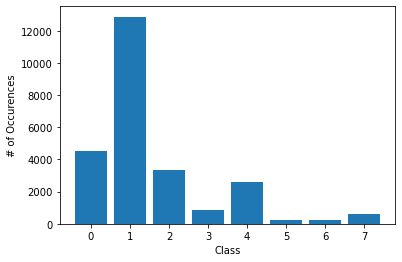

In [3]:
gnd_truth = pd.read_csv("data\SkinDiseaseDataset\ISIC_2019_Training_GroundTruth.csv")
#aug_df = pd.read_csv("data/augmentImageNameLabels.csv")
gnd_truth.head()

IMG_NAMES = gnd_truth['image']
TRAIN_IMG_RT_PATH = 'data/ISIC_2019_Training_Input/'
TEST_IMG_RT_PATH = 'data/ISIC_2019_Test_Input'
### No Examples of UNK so drop it
labels = np.array(gnd_truth.drop(columns = ["image", "UNK"]))

c, freq = np.unique(np.argmax(labels, axis= 1), return_counts = True)
plt.xlabel("Class")
plt.ylabel("# of Occurences")
plt.bar(c,freq)
print("# of occurences")
print(freq)
print("Classes")
print(c)

In [4]:
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

In [5]:
### Randomly Balance Sample from classes  
smpl_test_idxs = []
smpl_train_idxs = []
for i in range(len(labels[1])):
    idxs = np.array(returnClassIndex(labels, i))
    sel = np.random.RandomState(seed = 42).permutation(len(idxs))
    #print(len(idxs))
    ### Shuffle
    train_sel = list(sel[:int(0.75*len(idxs))])
    test_sel = list(sel[int(0.75*len(idxs)):])
    smpl_train_idxs += list(idxs[train_sel])
    smpl_test_idxs += list(idxs[test_sel])

paths = np.array([TRAIN_IMG_RT_PATH + m +'.jpg' for m in IMG_NAMES ])

In [6]:
im_size =200
channels = 3
num_classes = 8
lr = 0.001 ### learning rate
input_shape = ( im_size, im_size, channels)
l1_lambda = 0 ### L1 regularization lambda parameter
l2_lambda = 0
keep_prob =  0
batch_size = 16

In [7]:
tmpytr = labels[smpl_train_idxs]
tmpytst = labels[smpl_test_idxs]

In [8]:
true_train_class = [0,1]
true_train_class_idx = []
for i in true_train_class:
    if( i == 1):
        true_train_class_idx = true_train_class_idx + returnClassIndex(tmpytr,i)[:3000]
    else:
        true_train_class_idx = true_train_class_idx + returnClassIndex(tmpytr,i)[:3000]
false_train_class = [2,4]
false_train_class_idx = []
for i in false_train_class:
    false_train_class_idx = false_train_class_idx + returnClassIndex(tmpytr,i)

In [9]:
len(true_train_class_idx) + len(false_train_class_idx)

10460

In [10]:
len(tmpytr)

18996

In [11]:
true_test_class1 = [0,1]
true_test_class_idx1 = []
for i in true_test_class1:
    true_test_class_idx1 = true_test_class_idx1 + returnClassIndex(tmpytst,i)

### Selecting the classes
false_test_class = [2,3,4,5,6,7]
false_test_class_idx = []
for i in false_test_class:
    false_test_class_idx = false_test_class_idx + returnClassIndex(tmpytst,i)
trn_idx_shuffle = np.random.RandomState(seed= 42).permutation(
    len(true_train_class_idx + false_train_class_idx)
)
tst_idx_shuffle = np.random.RandomState(
    seed= 42).permutation(
    len(true_test_class_idx1 +false_test_class_idx)
)

In [12]:
train_trueX = paths[smpl_train_idxs][true_train_class_idx]
train_falseX = paths[smpl_train_idxs][false_train_class_idx]
bin_trainX = np.vstack([train_trueX.reshape(-1,1),
                        train_falseX.reshape(-1,1)])[trn_idx_shuffle]
bin_trainY = np.array((len(train_trueX)*[1]) + (len(train_falseX)*[0]))[trn_idx_shuffle]

test_trueX = paths[smpl_test_idxs][true_test_class_idx1]
test_falseX = paths[smpl_test_idxs][false_test_class_idx]
bin_testX = np.vstack([test_trueX.reshape(-1,1),
                       train_falseX.reshape(-1,1)])[tst_idx_shuffle]
bin_testY = np.array((len(test_trueX)*[1]) + (len(test_falseX)*[0]))[tst_idx_shuffle]

In [19]:
### Dataframes for Generator
train_df = pd.DataFrame({"filename":bin_trainX.ravel(),
                        "class": bin_trainY.astype(str)})
test_df = pd.DataFrame({"filename":bin_testX.ravel(),
                        "class": bin_testY.astype(str)})

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        samplewise_center = True,
        samplewise_std_normalization = True, 
        horizontal_flip=True,
        vertical_flip = True,
        shear_range=0.5,
        zoom_range=0.5,
        rotation_range = 30
)
batch_size = 25
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'binary',
    y_col="class",
    batch_size = batch_size, 
    target_size = (im_size, im_size),
    shuffle = False
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = 'binary',
    y_col="class",
    batch_size = batch_size,
    target_size = (im_size, im_size),
    shuffle = False
)

Found 10460 validated image filenames belonging to 2 classes.
Found 6335 validated image filenames belonging to 2 classes.


In [14]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3))
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
model = models.Sequential()
#model.add(layers.UpSampling2D((2,2)))
#model.add(layers.UpSampling2D((2,2)))
#model.add(layers.UpSampling2D((2,2)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='elu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='elu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
              loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_generator, epochs=20,
                    validation_data=test_generator
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 419 steps, validate for 254 steps
Epoch 1/20
419/419 [==============================] - 367s 876ms/step - loss: 0.4708 - acc: 0.7836 - val_loss: 0.7668 - val_acc: 0.7056
Epoch 2/20
419/419 [==============================] - 356s 849ms/step - loss: 0.4318 - acc: 0.8037 - val_loss: 0.5600 - val_acc: 0.7356
Epoch 3/20
419/419 [==============================] - 369s 881ms/step - loss: 0.4115 - acc: 0.8149 - val_loss: 0.5973 - val_acc: 0.7206
Epoch 4/20
419/419 [==============================] - 369s 880ms/step - loss: 0.3970 - acc: 0.8214 - val_loss: 0.7691 - val_acc: 0.7140
Epoch 5/20
419/419 [==============================] - 363s 867ms/step - loss: 0.3793 - acc: 0.8356 - val_loss: 0.8485 - val_acc: 0.7157
Epoch 6/20
419/419 [==============================] - 391s 934ms/step - loss: 0.3650 - acc: 0.8401 - val_loss: 0.7795 - val_acc: 0.7257
Epoch 7/20
419/419 [==============================] - 400s 954ms/step - loss: 0.3523 - acc

KeyboardInterrupt: 

In [54]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='binary_skin_disease_resnet_No_AUG_88acc.png')


scores = model.evaluate(test_generator, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


# Serialize model to JSON
model_json = model.to_json()
with open("Models/binary_skin_disease_resnet_No_AUG_88acc.json", "w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model.save_weights("Models/binary_skin_disease_resnet_No_AUG_88acc.h5")
print("Saved model to disk")

  ...
    to  
  ['...']
317/317 [==============================] - 117s 368ms/step - loss: 0.6541 - acc: 0.7274
acc: 72.74%
Saved model to disk


In [10]:
with open("Models/skin_disease_resnet_No_AUG_88acc.json", 'r') as j_file:
    loaded_model_json = j_file.read()
model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("Models/skin_disease_resnet_No_AUG_88acc.h5")
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',
              metrics=['acc']
             )

In [55]:
model.evaluate(test_generator)

  ...
    to  
  ['...']
396/396 [==============================] - 128s 323ms/step - loss: 0.3081 - acc: 0.8896


[0.3080926376084487, 0.8895817]

In [203]:
testY1 = []
preds1 = []

for i in tqdm(range(len(test_generator))):
    tmp = next(test_generator)
    preds1.append(model.predict_on_batch(tmp[0].astype(np.float32)))
    testY1.append(tmp[1].astype(np.float32))

100%|████████████████████████████████████████████████████████████████████████████████| 396/396 [03:01<00:00,  2.18it/s]


testY = []
preds = []
for i in tqdm(range(len(paths[smpl_test_idxs]))):
    img = plt.imread(paths[smpl_test_idxs][i])
    preds.append(model.predict(np.expand_dims(cv2.resize(img/255, (200,200)), axis = 0)))

In [88]:
t = np.vstack(testY1)
p = np.vstack(preds1)

In [89]:
t1 = np.argmax(t, axis =1 )

In [90]:
p1 = np.argmax(p,axis =1)

In [91]:
acc = accuracy_score(t1, p1)

In [199]:
p1

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [27]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve

f1 = f1_score(groundTruth, pred, average = "macro")
acc = accuracy_score(groundTruth, p_)
recall = recall_score(groundTruth, pred,average = "macro")
precision =precision_score(groundTruth, pred, average = "macro")
loss = log_loss(testY_,preds)

print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 1.6000934118313836
Accuracy: 0.5390686661404893
F1 Score: 0.13297292481672698
recall Score: 0.1515031825820848
Precision Score: 0.25332833124586684


c:\users\user\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
